In [1]:
!pip install git+https://github.com/speechbrain/speechbrain.git@develop

  Cloning https://github.com/speechbrain/speechbrain.git (to revision develop) to /tmp/pip-req-build-zb82lgjc
  Running command git clone --filter=blob:none --quiet https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-zb82lgjc
  Resolved https://github.com/speechbrain/speechbrain.git to commit dde231131c269f87031d79cacf7d6f6e787e610c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for speechbrain: filename=speechbrain-1.0.0-py3-none-any.whl size=800369 sha256=3bcde7812aeb90373b88ad04fa13887e24f22b66fa1da54fadb95bfb8f990fc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-x_rajh5m/wheels/e1/a5/ca/79fbb0a28f6f392850cfd5bac6a4dcec0f10a7e49d4c1e87cb
Successfully built speechbrain


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchaudio
import functools
from typing import Callable, Optional
import random
np.random.seed(1337) 
from tqdm import tqdm
import torch
import gc
from torch import nn 
from speechbrain.inference import EncoderClassifier
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as ls
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#train_mg_path1 = "/kaggle/input/mg-data-augmented/data_augmented/train/"
train_mg_path1 = "/kaggle/input/wav-mg/train/wav/"
train_mg_path = "/kaggle/input/dataflac-mg2/datawav2/"
train_path = "/kaggle/input/common-voice/cv-valid-train/cv-valid-train/"
test_mg_path = "/kaggle/input/wav-mg/val/wav/"
test_path = "/kaggle/input/spoken-language-identification/test/test/"


In [95]:
language_id = EncoderClassifier.from_hparams(source="speechbrain/lang-id-voxlingua107-ecapa", savedir="tmp",freeze_params=True,run_opts={'device':device})

In [77]:

# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in language_id.parameters() if p.requires_grad)

print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 0


In [7]:
file_count = len([name for name in os.listdir(train_mg_path1) if os.path.isfile(os.path.join(train_mg_path1, name))])

In [8]:
file_count

3098

In [9]:
features = []
labels = torch.tensor([]).to(device)  # Move labels tensor to GPU
n_train = file_count + 450
file_list = os.listdir(train_path)
random.shuffle(file_list)

for filename in file_list[:n_train]:
    labels = torch.cat((labels, torch.tensor([0]).to(device)), dim=0)  # Move label tensor to GPU
    signal = language_id.load_audio(train_path + filename)
    features.append(signal)

for filename in os.listdir(train_mg_path):
    labels = torch.cat((labels, torch.tensor([1]).to(device)), dim=0)  # Move label tensor to GPU
    signal = language_id.load_audio(train_mg_path + filename)
    features.append(signal)

for filename in os.listdir(train_mg_path1):
    labels = torch.cat((labels, torch.tensor([1]).to(device)), dim=0)  # Move label tensor to GPU
    signal = language_id.load_audio(train_mg_path1 + filename)
    features.append(signal)

max_length = 16000  # Desired length

# Truncate or pad each tensor in the features list to ensure they have the same size
features = [feature[:max_length] if len(feature) > max_length else torch.cat((feature, torch.zeros(max_length - len(feature)))) for feature in features]

# Now, stack the tensors
features = torch.stack(features, dim=0).to(device)  # Move features tensor to GPU


In [10]:
features.shape

torch.Size([7096, 16000])

In [11]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path) and file_path.endswith(".flac"):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

In [12]:
remove_folder_contents("/kaggle/working/tmp")

In [13]:
language_id.modules

<bound method Module.modules of EncoderClassifier(
  (mods): ModuleDict(
    (compute_features): Fbank(
      (compute_STFT): STFT()
      (compute_fbanks): Filterbank()
      (compute_deltas): Deltas()
      (context_window): ContextWindow()
    )
    (mean_var_norm): InputNormalization()
    (embedding_model): ECAPA_TDNN(
      (blocks): ModuleList(
        (0): TDNNBlock(
          (conv): Conv1d(
            (conv): Conv1d(60, 1024, kernel_size=(5,), stride=(1,))
          )
          (activation): ReLU()
          (norm): BatchNorm1d(
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): SERes2NetBlock(
          (tdnn1): TDNNBlock(
            (conv): Conv1d(
              (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
            )
            (activation): ReLU()
            (norm): BatchNorm1d(
              (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running

In [96]:
# Freeze all the parameters of the pretrained model
for param in language_id.parameters():
    param.requires_grad = False

# Unfreeze the top two layers for fine-tuning
"""unfreeze_layers = 0
for param in list(language_id.parameters())[-unfreeze_layers:]:
    param.requires_grad = True
"""
# Verify which layers are frozen and unfrozen
for name, param in language_id.named_parameters():
    print(f'Parameter: {name}, Requires Grad: {param.requires_grad}')

Parameter: mods.embedding_model.blocks.0.conv.conv.weight, Requires Grad: False
Parameter: mods.embedding_model.blocks.0.conv.conv.bias, Requires Grad: False
Parameter: mods.embedding_model.blocks.0.norm.norm.weight, Requires Grad: False
Parameter: mods.embedding_model.blocks.0.norm.norm.bias, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.tdnn1.conv.conv.weight, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.tdnn1.conv.conv.bias, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.tdnn1.norm.norm.weight, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.tdnn1.norm.norm.bias, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.res2net_block.blocks.0.conv.conv.weight, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.res2net_block.blocks.0.conv.conv.bias, Requires Grad: False
Parameter: mods.embedding_model.blocks.1.res2net_block.blocks.0.norm.norm.weight, Requires Grad: False
Parameter: mods.embedding_model.block

In [97]:

# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in language_id.parameters() if p.requires_grad)

print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 0


In [81]:
new_classifier = nn.Sequential(
    nn.Linear(107, 64),  # Increase the number of neurons in the first layer
    #nn.BatchNorm1d(1),  # Batch normalization layer
    nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU activation
    nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.5
    nn.Linear(64, 32),  # Linear layer 2
   # nn.BatchNorm1d(1),  # Batch normalization layer
    nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU activation
    nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.5
    nn.Linear(32, 1),  # Output layer for binary classification (output size is 1)
    nn.Sigmoid()
)

In [98]:
"""
language_id.mods.classifier.out = nn.Identity()
language_id.mods.classifier.softmax = nn.Identity()

language_id.mods.classifier.pop('softmax')

# Add the new output layer for binary classification
language_id.mods.classifier.add_module("out", binary_classifier)"""
classifier = language_id.mods.classifier# = binary_classifier

In [63]:
del classifier.softmax
del classifier.out
classifier

Classifier(
  (act): LeakyReLU(negative_slope=0.01)
  (norm): BatchNorm1d(
    (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (DNN): Sequential(
    (block_0): Sequential(
      (linear): Linear(
        (w): Linear(in_features=256, out_features=512, bias=True)
      )
      (act): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(
        (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [100]:
binary_classifier = nn.Sequential(
    classifier,
    nn.Linear(107, 1),  # Increase the number of neurons in the first layer
    #nn.BatchNorm1d(1),  # Batch normalization layer
    #nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU activation
   # nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.5
   # nn.Linear(256, 128),  # Linear layer 2
   # nn.BatchNorm1d(1),  # Batch normalization layer
   # nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU activation
   # nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.5
   # nn.Linear(128, 1),  # Output layer for binary classification (output size is 1)
    nn.Sigmoid()
)

In [83]:
binary_classifier = nn.Sequential(
    classifier,
    new_classifier
)

In [101]:
binary_classifier

Sequential(
  (0): Classifier(
    (act): LeakyReLU(negative_slope=0.01)
    (norm): BatchNorm1d(
      (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (DNN): Sequential(
      (block_0): Sequential(
        (linear): Linear(
          (w): Linear(in_features=256, out_features=512, bias=True)
        )
        (act): LeakyReLU(negative_slope=0.01)
        (norm): BatchNorm1d(
          (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (out): Linear(
      (w): Linear(in_features=512, out_features=107, bias=True)
    )
    (softmax): Softmax()
  )
  (1): Linear(in_features=107, out_features=1, bias=True)
  (2): Sigmoid()
)

In [102]:
language_id.mods.classifier = binary_classifier

In [103]:
language_id.mods.classifier

Sequential(
  (0): Classifier(
    (act): LeakyReLU(negative_slope=0.01)
    (norm): BatchNorm1d(
      (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (DNN): Sequential(
      (block_0): Sequential(
        (linear): Linear(
          (w): Linear(in_features=256, out_features=512, bias=True)
        )
        (act): LeakyReLU(negative_slope=0.01)
        (norm): BatchNorm1d(
          (norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (out): Linear(
      (w): Linear(in_features=512, out_features=107, bias=True)
    )
    (softmax): Softmax()
  )
  (1): Linear(in_features=107, out_features=1, bias=True)
  (2): Sigmoid()
)

In [104]:

# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in language_id.parameters() if p.requires_grad)

print("Number of trainable parameters:", num_trainable_params)

Number of trainable parameters: 108


In [105]:
criterion = nn.BCELoss()#.to(device)  # Binary Cross Entropy Loss
#criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss

optimizer = torch.optim.Adam(language_id.parameters(), lr=0.0001)
for param_group in optimizer.param_groups:
    param_group['params'] = [param.to(device) for param in param_group['params']]

In [106]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.1, random_state=42)

In [107]:
# Create DataLoader for training and validation sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [108]:

# Define a learning rate scheduler
scheduler = ls.ReduceLROnPlateau(optimizer, mode='min', factor=0.00001, patience=2, verbose=True)

In [109]:
num_epochs = 5
last_completed_epoch = 0
language_id.to(device)

best_val_loss = float('inf')  # Initialize the best validation loss
best_model_path = None  # Initialize the path to the best model

# Initialize arrays to store evaluation metrics
metrics_array = np.zeros((num_epochs, 12))  # 10 columns for Train Loss, Val Loss, Train Acc, Val Acc, Train Precision, Train Recall, Train F1, Train ROC AUC, Val Precision, Val Recall, Val F1, Val ROC AUC

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0
    train_predictions = []
    val_predictions = []
    train_labels = []
    val_labels = []

    # Training loop
    language_id.train()  # Set model to training mode
    for feature, label in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):
        feature, label = feature.to(device), label.to(device)
        outputs = language_id.forward(feature)
        loss = criterion(outputs[1].squeeze(), label.float())
        train_loss += loss.item() * feature.size(0)

        predicted = torch.round(outputs[1])
        train_correct += (predicted == label).sum().item()

        train_predictions.extend(predicted.cpu().detach().numpy())
        train_labels.extend(label.cpu().detach().numpy())

    train_precision = precision_score(train_labels, train_predictions)
    train_recall = recall_score(train_labels, train_predictions)
    train_f1 = f1_score(train_labels, train_predictions)
    train_roc_auc = roc_auc_score(train_labels, train_predictions)

    # Validation loop
    language_id.eval()
    with torch.no_grad():
        for feature, label in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):
            feature, label = feature.to(device), label.to(device)
            outputs = language_id.forward(feature)
            loss = criterion(outputs[1].squeeze(), label.float())
            val_loss += loss.item() * feature.size(0)

            predicted = torch.round(outputs[1])
            val_correct += (predicted == label).sum().item()

            val_predictions.extend(predicted.cpu().detach().numpy())
            val_labels.extend(label.cpu().detach().numpy())

    val_precision = precision_score(val_labels, val_predictions)
    val_recall = recall_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions)
    val_roc_auc = roc_auc_score(val_labels, val_predictions)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Store metrics in the array
    metrics_array[epoch] = [train_loss, val_loss, train_accuracy, val_accuracy, train_precision, train_recall, train_f1, train_roc_auc, val_precision, val_recall, val_f1, val_roc_auc]


Training Epoch 1/5: 100%|██████████| 50/50 [00:06<00:00,  7.33it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Validation Epoch 1/5: 100%|██████████| 23/23 [00:00<00:00, 25.79it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Training Epoch 2/5: 100%|██████████| 50/50 [00:06<00:00,  7.36it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

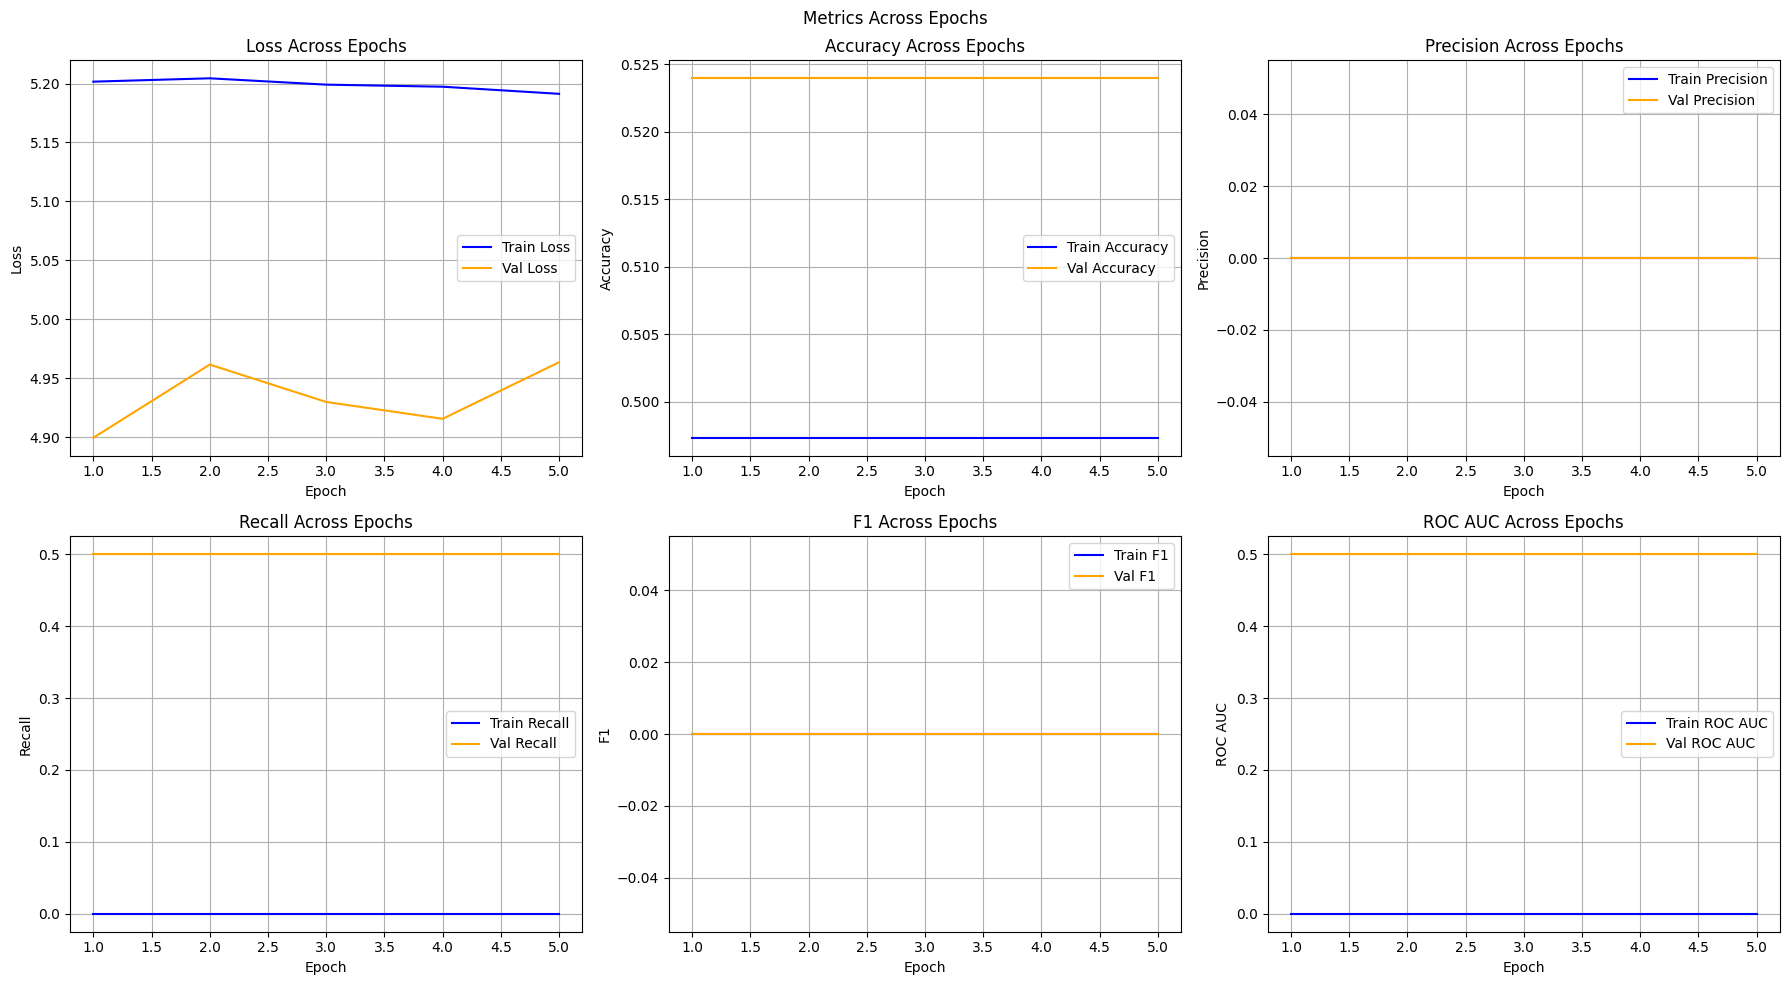

In [110]:

# Define the metric names for plotting
metric_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

# Create subplots for each metric
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Metrics Across Epochs')

for i, metric_name in enumerate(metric_names):
    row = i // 3
    col = i % 3
    axs[row, col].plot(range(1, num_epochs + 1), metrics_array[:, 2*i], label='Train ' + metric_name, color='blue')
    axs[row, col].plot(range(1, num_epochs + 1), metrics_array[:, 2*i+1], label='Val ' + metric_name, color='orange')
    axs[row, col].set_xlabel('Epoch')
    axs[row, col].set_ylabel(metric_name)
    axs[row, col].set_title(f'{metric_name} Across Epochs')
    axs[row, col].grid(True)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [94]:
#signal = language_id.load_audio("/kaggle/input/single-mg-voice/Baiboly malagasy vakina (Bible malgache lue oralement) - VEED - Online Video Editor - Video Editing Made Simple.mp3")
signal = language_id.load_audio("/kaggle/input/common-voice/cv-invalid/cv-invalid/sample-000000.mp3")

#input_tensor = torch.tensor(signal).to(device)  # Add batch dimension and move to device
input_tensor = torch.as_tensor(signal).unsqueeze(0).to(device)

# 3. Perform inference
# Set model to evaluation mode
language_id.eval()

# Forward pass to get predictions
with torch.no_grad():
    output = language_id(input_tensor)

# 4. Post-process predictions
# Process the model output as needed for your specific task
# Assuming output[1] contains the predictions
predicted_class = torch.round(output[1]).item()  # Assuming binary classification

# Print or use the predictions
print(predicted_class)

0.0


In [ ]:

"""
# Initialize tqdm to track progress
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_correct = 0
    val_correct = 0

    # Training loop
    language_id.train()  # Set model to training mode
    for feature, label in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}'):  # Use tqdm to track progress
        feature, label = feature.to(device), label.to(device)
        # Forward pass
        outputs = language_id.forward(feature)  # Forward pass
        loss = criterion(outputs[1].squeeze(), label.float())  # Calculate loss
        train_loss += loss.item() * feature.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = torch.round(outputs[1])
        train_correct += (predicted == label).sum().item()

    # Validation loop
    language_id.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for feature, label in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):  # Use tqdm to track progress
            feature, label = feature.to(device), label.to(device)
            # Forward pass
            outputs = language_id.forward(feature)  # Forward pass
            loss = criterion(outputs[1].squeeze(), label.float())  # Calculate loss
            val_loss += loss.item() * feature.size(0)

            # Calculate validation accuracy
            predicted = torch.round(outputs[1])
            val_correct += (predicted == label).sum().item()
            
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = f'best_model_epoch_{epoch}.pth'
        torch.save(language_id.state_dict(), best_model_path)

    # Calculate average losses and accuracy
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
"""